In [32]:
# Import libs, set canvas size for graphics
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [33]:
# read data 
data = pd.read_csv("assignment.csv", parse_dates=['date'], index_col="date")

In [34]:
# Overview the data
data.head()

,daily worker count
date,
2013-01-24,1
2013-01-25,1
2013-01-26,1
2013-01-27,2
2013-01-29,1


In [35]:
# See datatypes
data.dtypes

daily worker count    int64
dtype: object

In [36]:
# Make date column dataframe index
data.index

DatetimeIndex(['2013-01-24', '2013-01-25', '2013-01-26', '2013-01-27',
               '2013-01-29', '2013-01-31', '2013-01-02', '2013-03-02',
               '2013-04-02', '2013-05-02',
               ...
               '2017-07-22', '2017-07-23', '2017-07-24', '2017-07-25',
               '2017-07-26', '2017-07-27', '2017-07-28', '2017-07-29',
               '2017-07-30', '2017-07-31'],
              dtype='datetime64[ns]', name='date', length=1647, freq=None)

In [37]:
# index is not sorted. Let's sort it.
data = data.sort_index()

In [96]:
# From dataframe derieve a pandas series
ts = data[data.index >= '2015-01-01']['daily worker count']

In [97]:
# Show series
ts.head()

date
2015-01-01    5164
2015-01-02    4873
2015-01-03    5140
2015-01-04    7366
2015-01-05    7132
Name: daily worker count, dtype: int64

In [98]:
type(ts)

pandas.core.series.Series

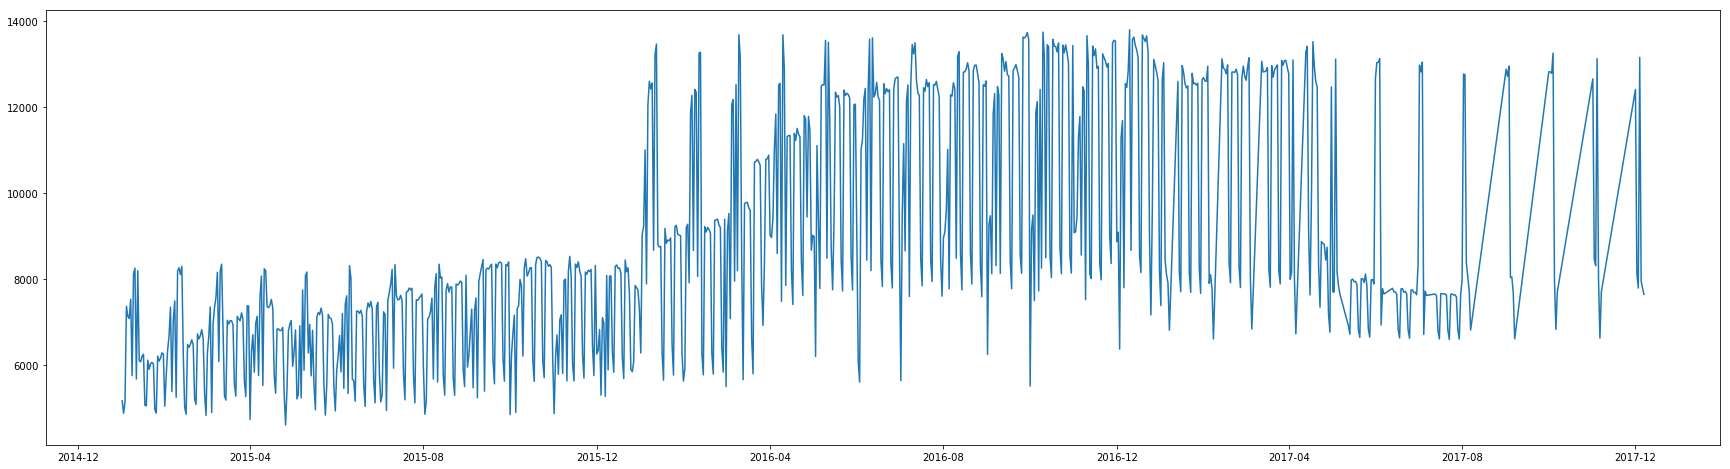

In [99]:
# Plot series
rcParams['figure.figsize'] = 30, 8
plt.plot(ts)

In [100]:
data.tail(20)

,daily worker count
date,
2017-10-02,12825
2017-10-03,12790
2017-10-04,13258
2017-10-05,7975
2017-10-06,6828
2017-10-07,7697
2017-11-01,12660
2017-11-02,8471
2017-11-03,8311


# How to check stationary

A TS is said to be stationary if its statistical properties such as mean, variance remain constant over time. This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary.

In [117]:
ts_log = ts
ts_log_diff = ts_log - ts_log.shift()

In [118]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [119]:
ts_log_diff.dropna(inplace=True)

C:\Users\toshiba\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
C:\Users\toshiba\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


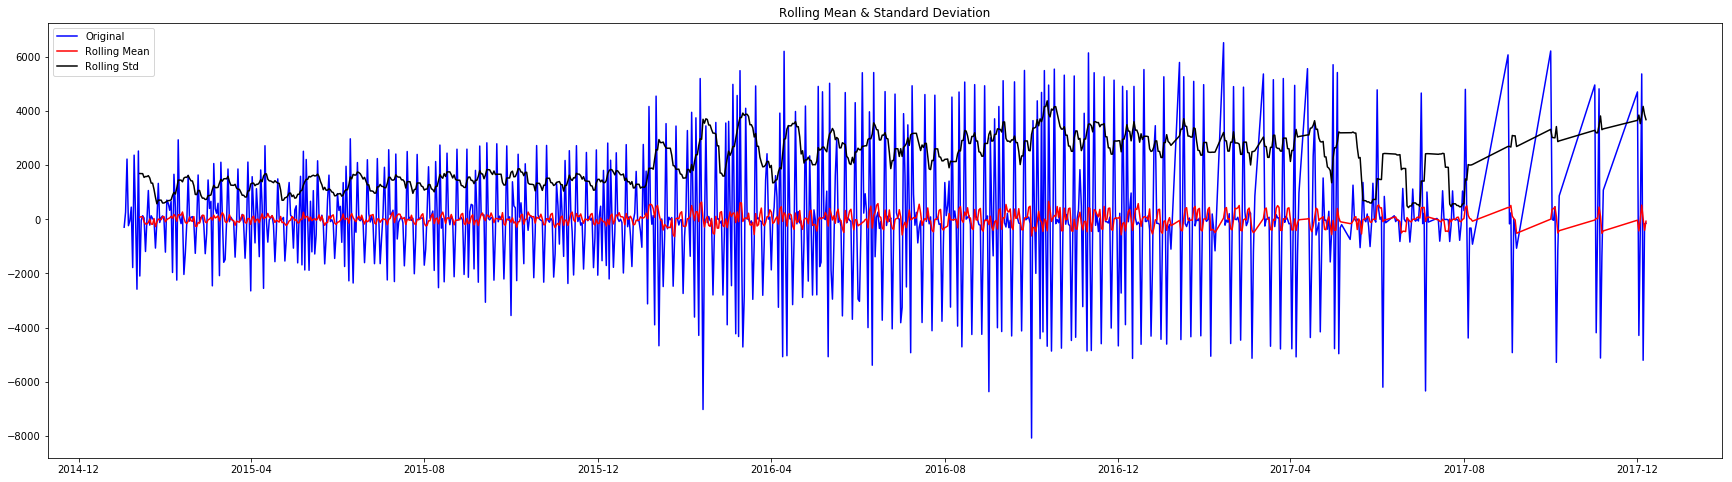

Results of Dickey-Fuller Test:
Test Statistic                -1.052364e+01
p-value                        9.540283e-19
#Lags Used                     2.100000e+01
Number of Observations Used    9.200000e+02
Critical Value (5%)           -2.864687e+00
Critical Value (10%)          -2.568445e+00
Critical Value (1%)           -3.437478e+00
dtype: float64


In [120]:
test_stationarity(ts_log_diff)

p value is less than %1. ts has become stationary.

# Forcasting Time Series

In [121]:
from statsmodels.tsa.stattools import acf, pacf

In [122]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

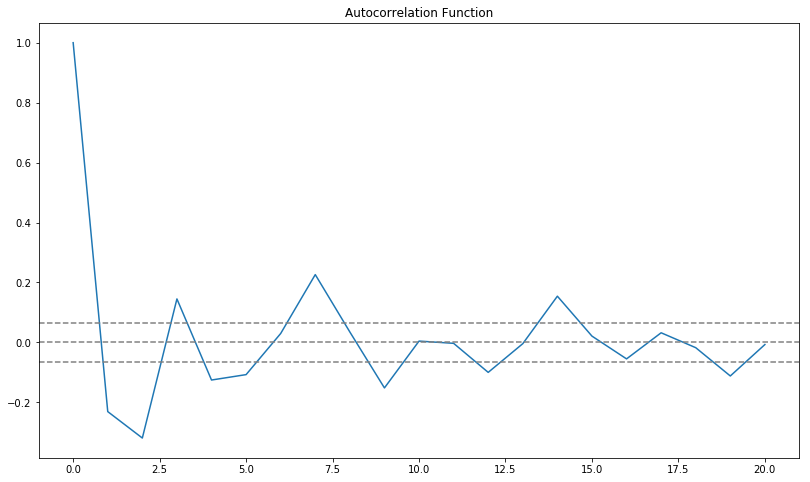

In [123]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

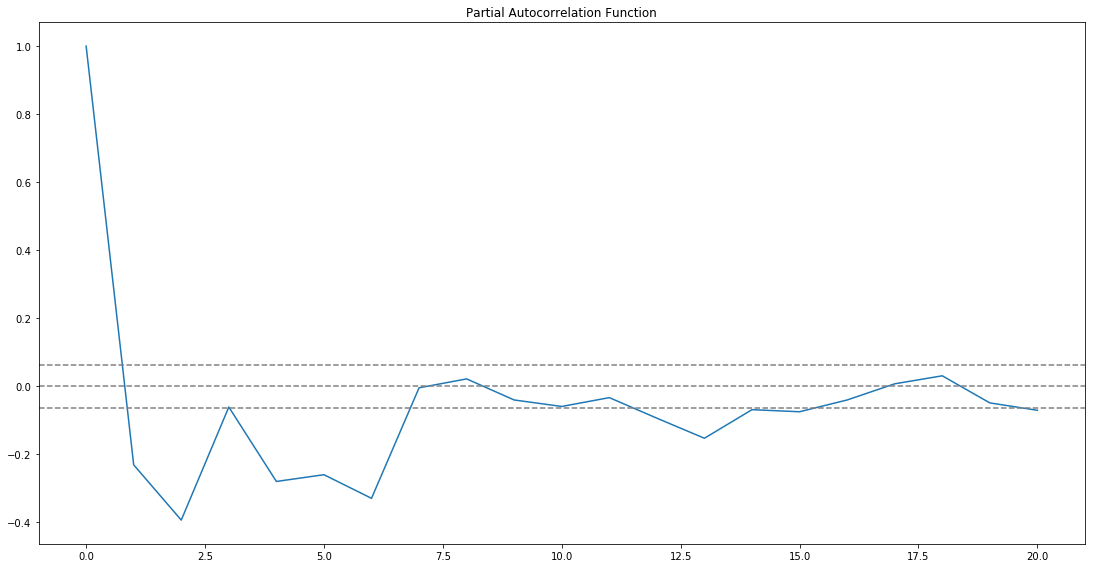

In [124]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [125]:
from statsmodels.tsa.arima_model import ARIMA

# AR Model

In [126]:
model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

TypeError: Cannot cast ufunc subtract output from dtype('float64') to dtype('int64') with casting rule 'same_kind'

# MA Model

In [127]:
model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

TypeError: Cannot cast ufunc subtract output from dtype('float64') to dtype('int64') with casting rule 'same_kind'

# Combined Model

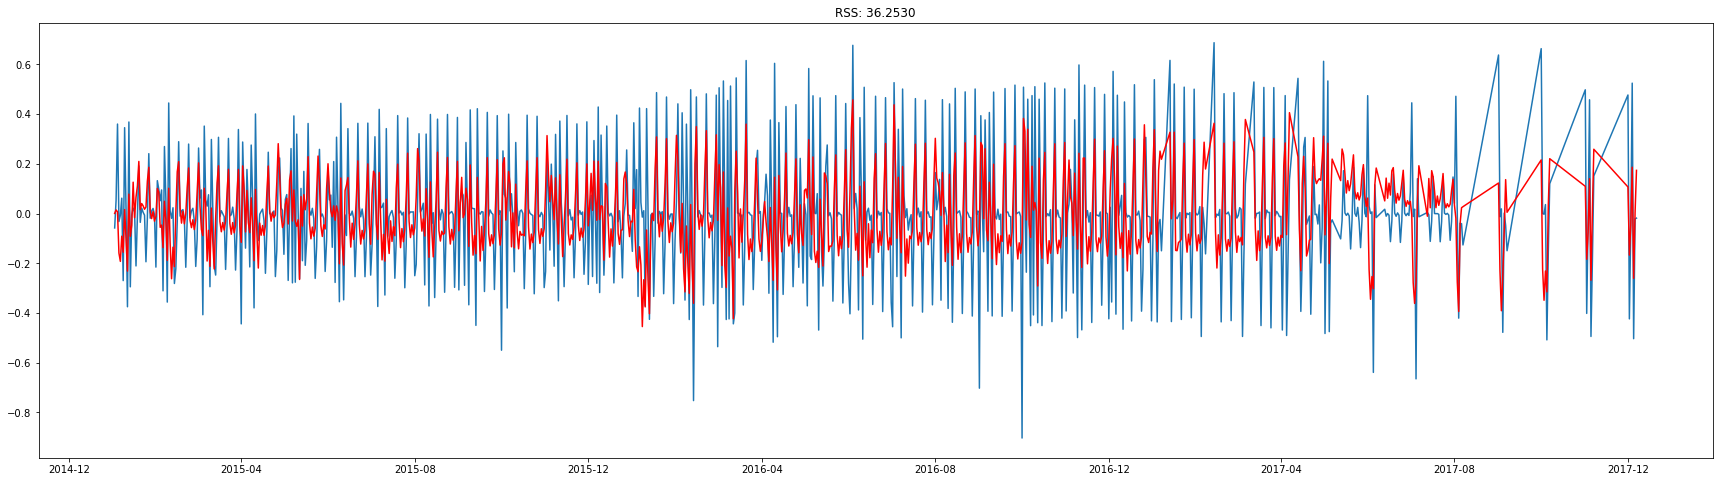

In [112]:
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

# Taking it back to original scale

In [113]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

date
2015-01-02    0.000386
2015-01-03    0.014397
2015-01-04    0.006869
2015-01-05   -0.159000
2015-01-06   -0.192515
dtype: float64

In [114]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

date
2015-01-02    0.000386
2015-01-03    0.014783
2015-01-04    0.021652
2015-01-05   -0.137349
2015-01-06   -0.329863
dtype: float64

In [115]:
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

date
2015-01-01    8.549467
2015-01-02    8.549853
2015-01-03    8.564250
2015-01-04    8.571119
2015-01-05    8.412118
dtype: float64

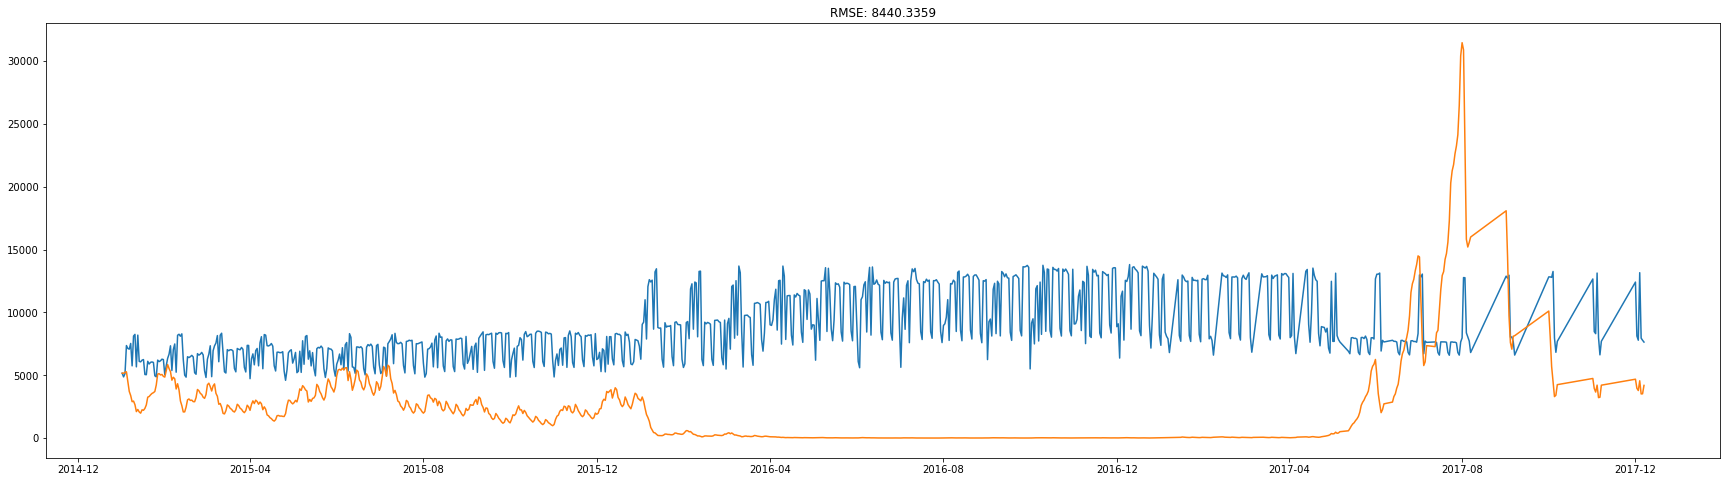

In [116]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))